This notebook generate all the figures used in ICASSP2024 paper.

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from scipy.linalg import polar

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]


import networkx as nx
import lib as gsp


# set random seed to get reproducible results
np.random.seed(7)

# Figure 1

In [2]:
G = nx.DiGraph()
nodelist = [0,1,2,3,4,5,6,7]
G.add_nodes_from(nodelist)
G.add_edges_from([(0,2), (0,3), 
                  (1,3),
                  (2,4),
                  (4,6), (4,7),
                  (5,7),
                  (6,0),
                  (7,0), (7,1)]) # M-block cyclic graph with M=4, N=8
A = nx.adjacency_matrix(G, nodelist=nodelist).todense()

In [3]:
# Bibliography graph
Bin = A@A.T
G_Bin = nx.from_numpy_array(Bin, create_using=nx.DiGraph)

# Co-citation graph
Cout = A.T@A
G_Cout = nx.from_numpy_array(Cout, create_using=nx.DiGraph)

In [4]:
# Polar decomposition!
Q, _ = polar(A)
Q = np.round(Q,5) # round to 5 decimal places to force sparsity

# added edges in Q which are not in A
added_edges = ((Q!=0) & (A==0)).astype(int)
G_added_edges = nx.from_numpy_array(added_edges, create_using=nx.DiGraph)

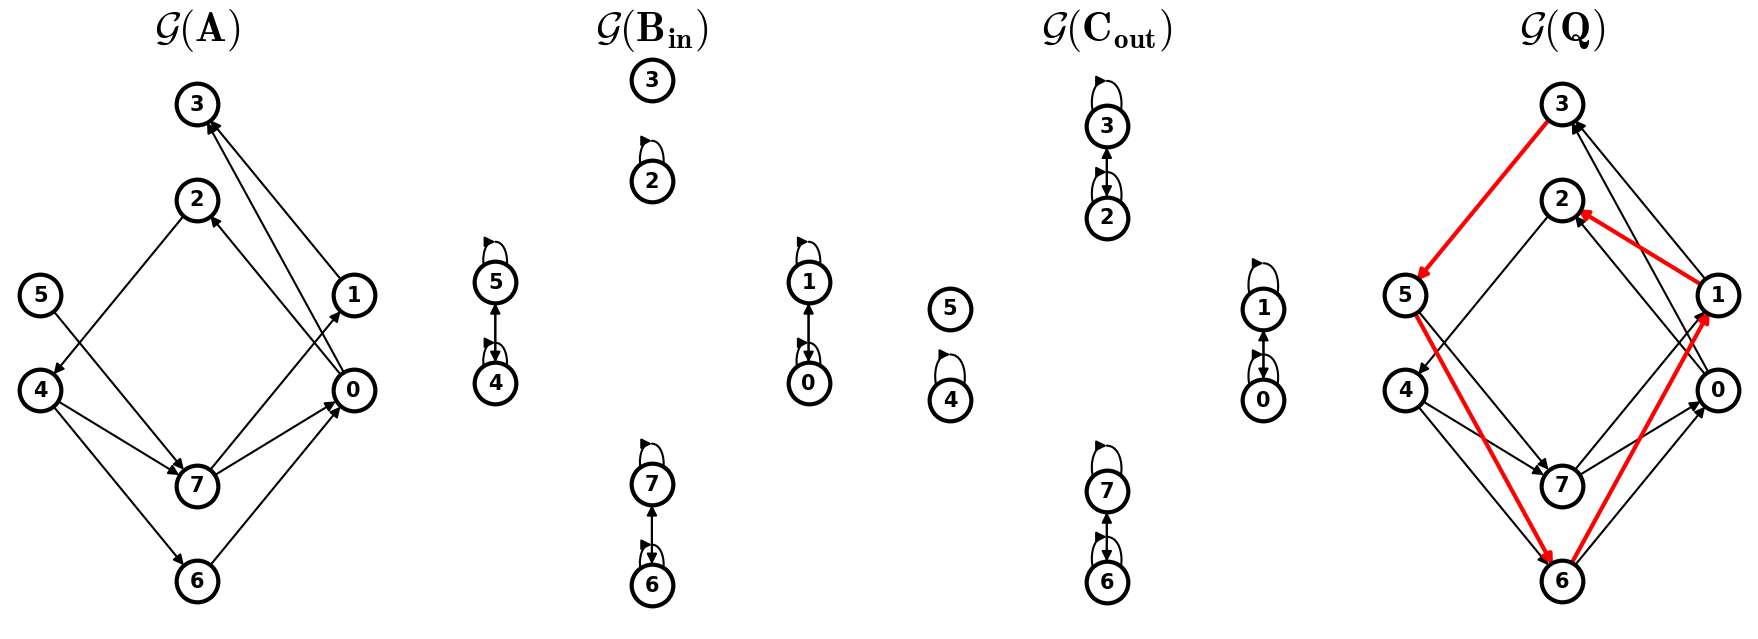

In [5]:
# Ok let's plot

# First, set position of nodes
n_per_node = 2
M = 4
pos = gsp.block_circular_layout(G, [n_per_node]*M)

# draw options for nodes
draw_options = dict(node_size=400, node_color='white', edgecolors='black', 
                    with_labels=True, linewidths=2, font_size=10, font_weight='bold')

# titles of each subplot
graph_notation = lambda g: r'$\mathcal{G}(\mathbf{%s})$' % g
titles = [f"{graph_notation('A')}",
          f"{graph_notation('B_{in}')}",
          f"{graph_notation('C_{out}')}",
          f"{graph_notation('Q')}"]

fig, axes = plt.subplots(1,4, figsize=(15,5))

for i, (G_, title) in enumerate(zip([G, G_Bin, G_Cout], titles)):
    axes[i].set_title(title, fontsize=20)
    nx.draw(G_, pos=pos, **draw_options, ax = axes[i])
    
axes[-1].set_title(titles[-1], fontsize=20)
nx.draw(G, pos=pos, **draw_options, ax = axes[-1])
nx.draw_networkx_edges(G_added_edges, pos=pos, ax = axes[-1], edge_color='red', width=2)

# Figure 2

In [6]:
M = 4 # Number of blocks
n_per_block = 25 # number of nodes per block = L*L
N = n_per_block*M

sparcity = [0.5]*M # sparcity of each block to block connections
A = gsp.balanced_M_block_cyclic_graph(M, N, sparcity = sparcity) # generate graph (algebraic representation)
Q, F, P = gsp.polar_decomposition_based_on_M_block_cyclic_graph(A, M, N) # polar decomposition that preserves the block structure

# graph
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
pos = gsp.block_circular_layout(G, [N//M]*M, outer_scale = 3, inner_scale = 1)

In [7]:
# GFT of A
L, U = np.linalg.eig(A)

# GFT of Q
LQ, UQ = np.linalg.eig(Q) 

# GFT of P
LP, UP = np.linalg.eigh(P) 

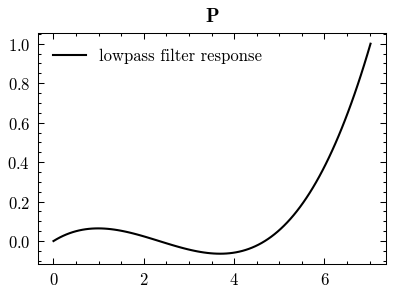

In [8]:
# filter design for P

mag_tabs = 4
null_sigma_points = np.linspace(0, LP.max(), mag_tabs)

pass_mag_low = LP.max() # low pass filter
null_sigma_points_low = [sigma for sigma in null_sigma_points if not np.isclose(sigma,pass_mag_low)]

# polynomial filter
pr_low_ = lambda L: np.linalg.multi_dot([(L-s*np.eye(L.shape[0])) for s in null_sigma_points_low])
pr_low_max = pr_low_(np.array([pass_mag_low]))
pr_low = lambda L: pr_low_(L)/pr_low_max

# plot
r = np.linspace(0, LP.max(), 100)
low_response = pr_low(np.diag(r))

plot = pd.DataFrame({'lowpass filter response': np.diag(low_response)}, index=r).plot(title=r'$\mathbf{P}$')

/workspaces/Digraph_GFT/env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/workspaces/Digraph_GFT/env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


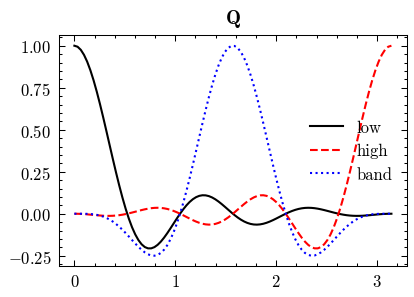

In [9]:
# filter design for Q
phase_tabs = 4
null_phase_points = np.linspace(0, np.pi, phase_tabs)

pass_phase_high = np.pi # high pass filter

null_phase_points_high = [phase for phase in null_phase_points if not (np.isclose(phase,pass_phase_high))]
null_phase_points_high_negative = [-p for p in null_phase_points_high]
null_phase_points_high = null_phase_points_high + null_phase_points_high_negative

pass_phase_low = 0# low pass filter
null_phase_points_low = [phase for phase in null_phase_points if not (np.isclose(phase,pass_phase_low))]
null_phase_points_low_negative = [-p for p in null_phase_points_low]
null_phase_points_low = null_phase_points_low + null_phase_points_low_negative

ptheta_low_ = lambda L: np.linalg.multi_dot([L-p1*np.eye(L.shape[0]) for p1 in np.exp(1j*np.array(null_phase_points_low))])
pass_phase_low_max = ptheta_low_(np.exp(1j*np.array([pass_phase_low])))
ptheta_low = lambda L: ptheta_low_(L)/pass_phase_low_max

ptheta_high_ = lambda L: np.linalg.multi_dot([L-p1*np.eye(L.shape[0]) for p1 in np.exp(1j*np.array(null_phase_points_high))])
ptheta_high_max = ptheta_high_(np.exp(1j*np.array([pass_phase_high])))
ptheta_high = lambda L: ptheta_high_(L)/ptheta_high_max

ptheta_band_ = lambda L: np.linalg.multi_dot(3*[L-np.eye(L.shape[0])]+3*[L+np.eye(L.shape[0])])
ptheta_band_max = ptheta_band_(np.array([np.exp(1j*1/2*np.pi)]))
ptheta_band = lambda L: ptheta_band_(L)/ptheta_band_max

# plot
theta = np.linspace(0, np.pi, 100)
low_response = ptheta_low(np.diag(np.exp(1j*theta)))
high_response = ptheta_high(np.diag(np.exp(1j*theta)))
band_response = ptheta_band(np.diag(np.exp(1j*theta)))
plot = pd.DataFrame({
              'low': np.diag(low_response), 
              'high': np.diag(high_response), 
              'band': np.diag(band_response)
              }, index=theta).plot(title=r'$\mathbf{Q}$')

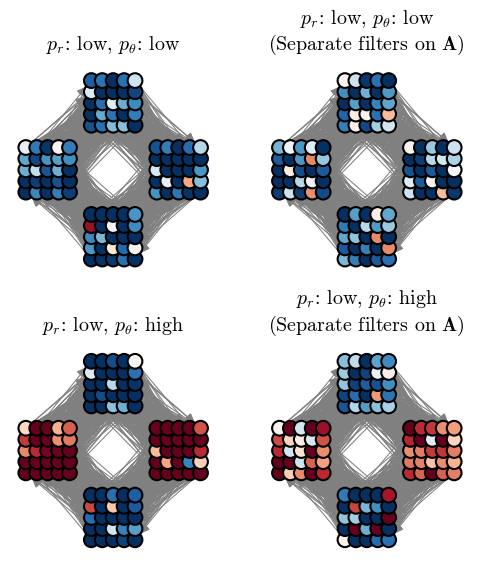

In [10]:
ys = []

# random iid signal
g_signal = np.random.randn(np.sum(N), 1).reshape(-1,1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4,4.3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
filter_set = ((pr_low, ptheta_low), 
              (pr_low, ptheta_high))

names = (('low', 'low'),
         ('low', 'high'))
titles = []
for i, (filters, name) in enumerate(zip(filter_set, names)):
        
        # cascade filtering. Note that the filtering is on node domain so it doesn't need spectral decomposition
        filtered_signal = filters[0](P)@g_signal
        filtered_signal = filters[1](Q)@filtered_signal


        ys.append(np.real(filtered_signal.flatten()))
        title = r"$p_r$"+f": {name[0]}, "+r"$p_\theta$"+f": {name[1]}"
        titles.append(title)
        if i == 0: vmax = 0.1
        else: vmax = np.max(np.abs(np.real(filtered_signal)))/3
        nx.draw(G, pos=pos, node_color=np.real(filtered_signal.flatten()), ax=axes[i,0], edgecolors='k',
                node_size=50, edge_color='gray', width=0.5, cmap='RdBu', vmin=-vmax, vmax=vmax)
        axes[i,0].set_title(title)


for i, (filters, name) in enumerate(zip(filter_set, names)):
# spectral filtering. It requires eigen-decomposition of A
        filtered_signal = U@( filters[0](np.diag(np.abs(L))) * filters[1](np.diag(L/np.abs(L))) )@np.linalg.inv(U)@g_signal

        ys.append(np.real(filtered_signal.flatten()))
        title = r"$p_r$"+f": {name[0]}, "+r"$p_\theta$"+f": {name[1]}\n(Separate filters on "+r"$\mathbf{A}$"+")"
        titles.append(title)

        if i == 0: vmax = 0.1
        else: vmax = np.max(np.abs(np.real(filtered_signal)))/3
        nx.draw(G, pos=pos, node_color=np.real(filtered_signal.flatten()), ax=axes[i,1], edgecolors='k',
                node_size=50, edge_color='gray', width=0.5, cmap='RdBu', vmin=-vmax, vmax=vmax)
        axes[i,1].set_title(title)

# Figure 3

In [11]:
signals = pd.DataFrame(ys, index=titles)
freq_a = pd.DataFrame([np.squeeze(np.asarray((np.linalg.inv(U)@np.expand_dims(signals.T[i], 1)))) for i in titles], 
                      index=titles, columns=np.abs(1-L/np.max(np.abs(L)))).sort_index(axis = 1)
freq_p = pd.DataFrame([np.squeeze(np.asarray((UP.T@np.expand_dims(signals.T[i], 1)))) for i in titles], index=titles, columns=(1-LP/LP.max())).sort_index(axis=1)
freq_q = pd.DataFrame([np.squeeze(np.asarray((UQ.conj().T@np.expand_dims(signals.T[i], 1)))) for i in titles], index=titles, columns=np.angle(LQ)).sort_index(axis = 1)
freq_q = freq_q.T.loc[freq_q.columns >= 0].T  # only positive angles

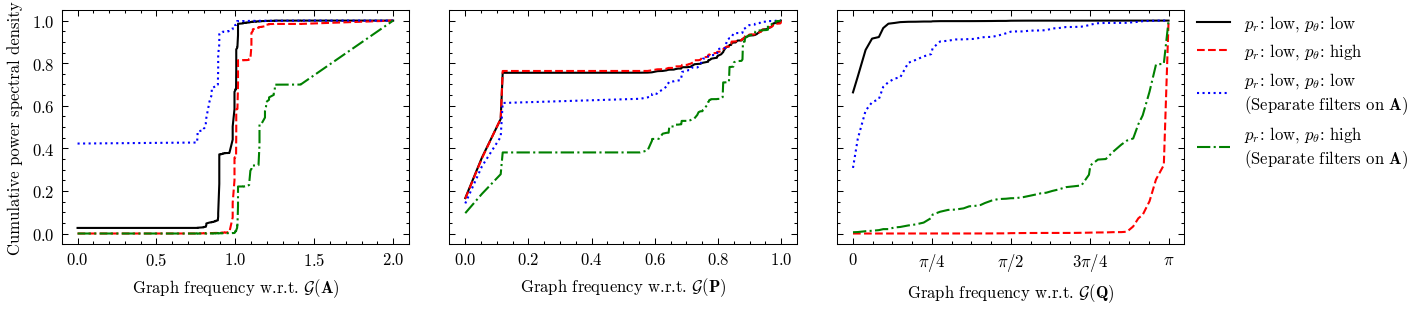

In [12]:
y_range=[0, 1.0]
xtitle = ['Graph frequency w.r.t. '+r'$\mathcal{G}(\mathbf{A})$',
          'Graph frequency w.r.t. '+r'$\mathcal{G}(\mathbf{P})$',
          'Graph frequency w.r.t. '+r'$\mathcal{G}(\mathbf{Q})$']

marker_shapes = ['circle', 'square', 'diamond', 'cross']
column_names = ['k=0', 'k=1', 'k=2', 'k=100']
symbol_map = {cn: ms for cn, ms in zip(column_names, marker_shapes)}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,2), sharey=True)
fig.tight_layout()

for figs in zip([freq_a, freq_p, freq_q], [1, 2, 3]):
    freq, index = figs
    cpsd = gsp.cum_psd(freq)
    cpsd.plot(xlabel=xtitle[index-1], ylabel='Cumulative power spectral density', ax=axes[index-1])
    
    if index==3:
        axes[index-1].set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
        labels = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
        axes[index-1].set_xticklabels(labels)
        
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].legend(loc='upper center', bbox_to_anchor=(1.34, 1.05), ncol=1)
fig.show()